## Warsztaty badawcze - praca domowa IV dane obrazowe
W poniższym skrypcie dokonana zostanie unifikacja, standaryzacja oraz metody wstępnego preprocesingu dla danych pochodzących z potencjalnie wielu baz danych oraz potencjalnie wielu formatach.  
Plik ma służyć rónież jako pipeline łączący dane i przygotowywujący je do operacji na całości zbioru, by w przyszłości łatwo móc dokonać treningu modelu na pełnej okazjalności danych.

## Importy

In [182]:
import numpy as np
import pandas as pd
import os
import glob
from pydicom import dcmread
import PIL
from PIL import Image
from skimage.transform import resize, rescale
import cv2
from matplotlib import pyplot as plt

## Definiowanie funkcji do preprocesingu
By zadbać o modularność całości programu, poniżej dokonam zdefiniowania wielu funkcji odpowiadających za poszczególne kroki.  
**Uwaga** zdjęcia RTG I CT będą traktowane oddzielnie i należy sprecyzować jakiego typu dane są brane pod uwagę.  
W przypadku CT, jedna z naszych rozpatrywanych baz zawiera zdjęcia 3D tomografi komputerowej. Zdjęcia te są uszeregowane jako wiele plików 2D, zatem nie wymagane jest żaden dodatkowy krok w ich obróbce.

Poniżej funkcja pobierająca obrazy w formie arrayów dla każdego z rozpatrywanych formatów w naszych bazach danych.  Jako argument należy podać ścieżki do katalogów z obrazami.

In [33]:
def get_data_from_paths(*PATHS):
    dicom_photo_array = []
    png_photo_array = []
    jpg_photo_array = []
    for PATH in PATHS:
        for file in glob.glob(PATH + '/*.dcm'):
            print(file)
            dicom_photo_array.append(dcmread(file).pixel_array)
        for file in glob.glob(PATH + '/*.png'):
            image = PIL.Image.open(file)
            image = np.array(image)
            png_photo_array.append(image)
        for file in glob.glob(PATH + '/*.jpg'):
            image = PIL.Image.open(file)
            image = np.array(image)
            jpg_photo_array.append(image)
    return dicom_photo_array, png_photo_array, jpg_photo_array

Poniżej funkcja standaryzująca dane, tudzież dokonuje ujednolicenia rozmiarów obrazów, przeskalowuje je na odcienie szarości (odcień szarości był dominującym typem w naszych bazach, dlatego pozostałe trójkanałowe przeskalowaliśmy do szarości).  
Standaryzacja wymiarów odbywa się pierwotnie na przeskalowaniu wszystkich niekwadratowych obrazów na kwadratowe (stosując średnią dwóch wymiarów), a następnie na obliczeniu średniej wymiarów ze wszystkich obrazów (już kwadratowych) i zeskalowaniu ich.  
Dodatkowo przy skalowaniu dokonywana jest operacja anty aliasingu.

In [234]:
#postanowiliśmy ustandaryzować wymiary biorąc średią i uznając kwadratowość obrazów (niekwadratowe przeskalowano do kwadratowych)
#zakłada, że dane są w grayscale
def standardize_size(data_array):
    
    def make_square(data):
        if data.shape[0] != data.shape[1]:
            avg = (data.shape[0] + data.shape[1])/2
            return cv2.resize(data, (int(avg), int(avg)),Image.ANTIALIAS)
        else:
            return data
    def resize_all(data,average):
        return cv2.resize(data,(average,average),Image.ANTIALIAS)
    
    if len(data_array) == 0:
        return []
    data_square = [make_square(data) for data in data_array]
    
    suma = 0
    for i in data_square:
        suma += i.shape[0]
    average = int(suma/len(data_array))
    data_standard = [resize_all(data,average) for data in data_square]
    return data_standard
    

Funkcja skalująca obrazy RGB do skali szarości, używając przekształcenia macierzowego.

In [87]:
def make_grayscale(data_array):
    gray_scale = []
    
    def rgb2gray(rgb):
        return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
    
    for data in data_array:
        if len(data.shape) == 3 and data.shape[2] == 3:
            data = rgb2gray(data)
            gray_scale.append(data)
        else:
            gray_scale.append(data)
            continue
    return gray_scale

Funkcja zapisująca pliki do jednego folderu (opcjonalnie), w postaci csv bądź plików jpg.

In [172]:
def save_to_output(output_file_set,output_path,to_csv = False, to_img = True):
    PATH = os.path.abspath(output_path + "/photo_data.csv")
    if to_csv:
        pd.DataFrame(output_file).to_csv(PATH)
    if to_img:
        for i,im in enumerate(output_file_set):
            #im = Image.fromarray(im)
            PATH = output_path + '/' + str(i) + "_file.jpg"
            PATH = os.path.abspath(PATH)
            cv2.imwrite(PATH, (im))
            #im.save(PATH)

Funkcja składająca unifikująca wszystkie poprzednie w jednej oraz zwracająca przekonwertowane obrazy ze wszystkich baz w formie jednej listy obiektów typu np.array.  

In [245]:
def execute_pipeline(output_path,*PATHS,to_csv=False,to_img=True):
    dicom,png,jpg = get_data_from_paths(*PATHS)
    
    dicom,png,jpg = make_grayscale(dicom),make_grayscale(png),make_grayscale(jpg)
    
    imgs_concatenated = [*dicom,*png,*jpg]
    
    imgs_concatenated = standardize_size(imgs_concatenated)
    
    save_to_output(imgs_concatenated,output_path,to_csv,to_img)
    
    
    return imgs_concatenated
    
    

## Testowanie
Po zdefiniowaniu naszych funkcji do preprocesingu, zajmijmy się przetestowaniem działania naszego programu.

In [173]:
#Ścieżki z przykładowymi danymi obrazowymi występującymi w naszych bazach danych
PATH_LIDC = r"C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample"
PATH_SIM_ACR = r"C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample"
PATH_CXR2 = r"C:\Users\aaf6\Desktop\WB-2\Data\jf_dane\obrazowe-covidx-cxr2"
PATH_QDATA = r"C:\Users\aaf6\Desktop\WB-2\Data\jf_dane\obrazowe-qata\obrazy"
PATH_RSNA = r"C:\Users\aaf6\Desktop\WB-2\Data\pr_dane\RSNA\stage_2_test_images"
PATH_SHENZEN = r"C:\Users\aaf6\Desktop\WB-2\Data\pr_dane\SHENZEN\CXR_png"

In [235]:
PATHS = [PATH_LIDC,PATH_SIM_ACR,PATH_CXR2,PATH_QDATA,PATH_RSNA,PATH_SHENZEN]

In [246]:
Images_data = execute_pipeline(r'C:\Users\aaf6\Desktop\WB-2\Data\Concat_data',*PATHS)

C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample\1-001.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample\1-002.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample\1-003.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample\1-004.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\LIDC-IDRI_sample\1-005.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample\ID_00b0e5a9f.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample\ID_00b115bfe.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample\ID_00d054471.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample\ID_00f04769e.dcm
C:\Users\aaf6\Desktop\WB-2\Data\jg_dane\siim-acr-pneumothorax-segmentation_sample\ID_00f715288.dcm
C:\Users\aaf6\Desktop\WB-2\Data\pr_dane\RSNA\stage_2_test_images\00b4e593-fcf8-488c-ae55-751034e26f16.dcm
C:\Users\aaf6\Desktop\WB-2\Data\pr_dane\RSNA\stage_2_test_images

In [247]:
#W sumie po 5 obrazów z 6 baz czyli 30
#Obrazy zostały również zapisane do folderu, jednakże nie jestem w stanie udowodnić tego w tym notatniku
len(Images_data)

30

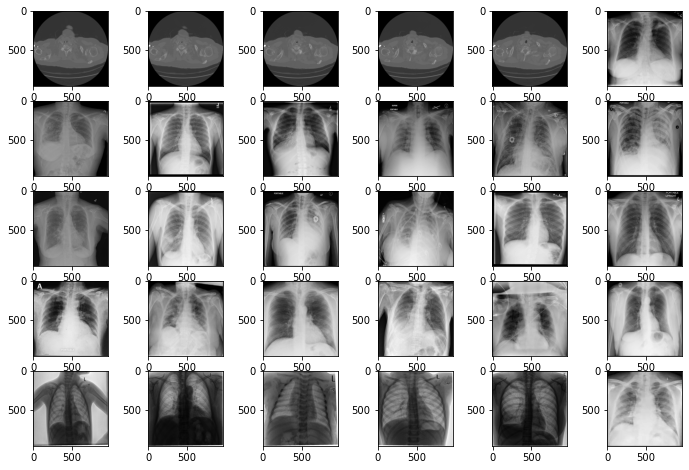

In [262]:
#Pokażmy jak prezentują się ustandaryzowane obrazy poniżej
f, axarr = plt.subplots(5,6,figsize=(12,8))
for i in range(30):
    axarr[i//6,i%6].imshow(Images_data[i],cmap="gray")